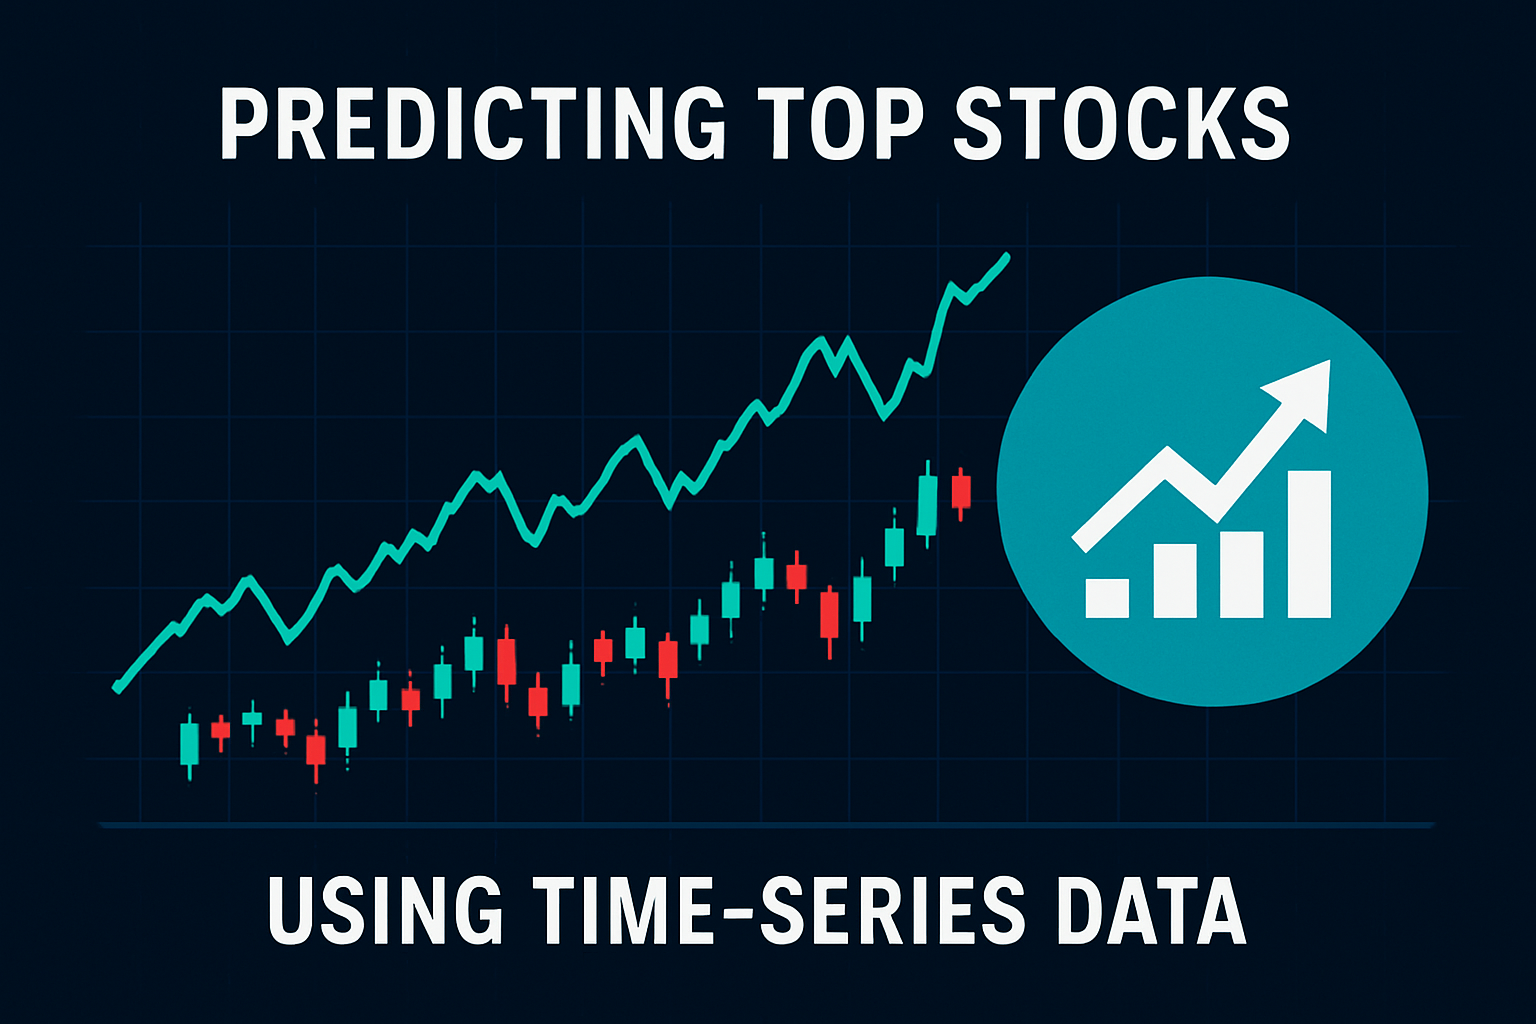

In this python notebook, we will explore and predict the stock prices of the top US stocks like Tesla (TSLA), Apple (AAPL), Google and Microsoft (MSFT) using both Exploratory Data Analysis (EDA) and various Machine Learning models. We will use yfinance to get the last 5 years of time-series data for these stocks, and visualize different aspects of it using Seaborn and Matplotlib. yfinance is an open-source Python library that provides an easy way to download financial and market data from Yahoo! Finance's public APIs. We will then look at a few ways of analyzing the price of a stock, based on its previous performance history,daily traded volumes etc.



# 📊 Stock Price Prediction Project

### 🔎 Project Summary  

This project aims to explore and predict the stock prices of **Tesla (TSLA)**, **Apple (AAPL)**, **Google(GOOG)**, and **Microsoft (MSFT)** using both **Exploratory Data Analysis (EDA)** and various **Machine Learning / Time-Series models**.  

The workflow is divided into two main parts:  

1. **Exploratory Data Analysis (EDA)**  
   - Clean and preprocess stock data.  
   - Summarize key statistics.  
   - Visualize stock price trends, daily returns, volatility, correlations, and cumulative returns.  
   - Apply **feature engineering** (moving averages,lagged features, returns, volatility,Macroeconomic indicators).  

2. **Baseline Model (Linear Regression)**  
   - Build a regression model to predict next 7 days of stock prices.  
   - Establish a baseline for comparing more advanced models.  

3. **Advanced Models (in next steps)**  
   - Random Forest Regressor  
   - ARIMA  
   - LSTM  

4. **Model Evaluation & Comparison (in next steps)**  
   - Use metrics such as RMSE, MAE, and R².  

### 📌 Expected Outcomes  
- Identify stock behavior patterns (trends, volatility, correlations).  
- Build a benchmark model and iteratively improve predictions.  
- Generate structured **visualizations and insights** for deeper modeling.



In [378]:
# Required libraries:
# - yfinance: To fetch historical stock data.
# - pandas, numpy: For data manipulation.
# - scikit-learn: For data splitting and Linear Regression model.
# - matplotlib, seaborn: For data visualization.

# Installation:
# To run this script, we must first install the required packages:
# pip3 install yfinance pandas numpy scikit-learn matplotlib seaborn


In [387]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os


In [388]:
# Define the directory to store stock data
DATA_DIR = 'top_usa_stocks_data'

# Define the directory to store final results
RESULTS_DIR = 'results'
# Define the directory for plots
PLOTS_DIR = 'eda_plots' # New directory for plots
# Configuration
stock_tickers = ['AAPL', 'GOOG', 'MSFT', 'TSLA']
start_date = '2020-09-26'
end_date = '2025-09-26'
time_step = 60 # Past days for features
forecast_days = 7 # Number of days to predict into the future
target_column = 'Adj Close' # Using Adjusted Close price for better modeling as it accounts for corporate actions like stock splits and dividends.

# Define Macro economic Tickers to download like market volatility index, S&P 500 stocks index. 
MACRO_TICKERS = {
    "VIX": "^VIX",
    "SPY": "SPY"
}

In [389]:
# Ensure necessary directories exist
for directory in [DATA_DIR, PLOTS_DIR, RESULTS_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

In [390]:
# Notebook configuration and plot styles
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.style.use("seaborn-v0_8-darkgrid")

**Data Download function**

This function will download 5 years of time-series data for each of the stocks mentioned in the stock_tickers. Our target column is Adjusted closing price which accounts for corporate actions like stock splits and dividends and is the best column for doing prediction.

In [391]:
# Getting the stocks data
def get_stock_data(ticker, start, end):
    """Downloads stock data or loads from local file, ensuring Adj Close is used and cleaning CSV format."""
    file_path = os.path.join(DATA_DIR, f'{ticker}_{start}_{end}.csv')
    df = None
    
    # Flag to determine if we need to try re-downloading
    data_loaded_successfully = False

    if os.path.exists(file_path):
        try:
            # Handle the header rows in the local CSV 
            # We skip the first row (the 'Price' row) and set the header to row 1 (the 'Date' row)
            df = pd.read_csv(file_path, index_col=0, parse_dates=True, skiprows=1, header=0)
            
            # Drop any empty columns that might be created by inconsistent saving/reading
            df = df.dropna(axis=1, how='all')
            df.columns = df.columns.str.strip() # Clean up any whitespace in column names
            
            # Ensure Data Integrity 
            if 'Adj Close' in df.columns:
                df['Close'] = df['Adj Close']
            elif 'Close' in df.columns:
                pass # Already have the close column
            else:
                 # If essential columns are missing after cleaning, force a re-download
                 raise KeyError(f"Required column 'Adj Close' or 'Close' missing after local load.")

            # Final check that the DataFrame is not inadvertently empty
            if not df.empty:
                data_loaded_successfully = True

        except Exception as e:
            print(f"Warning: Local data file reading failed for {ticker}. Error: {e}. ")
            
            # DELETE CORRUPTED FILE TO FORCE FRESH DOWNLOAD 
            if os.path.exists(file_path):
                os.remove(file_path)
                print(f"Deleted corrupted file: {file_path}")
            
            data_loaded_successfully = False

    if not data_loaded_successfully:
        # Download and save, fetching the Adj Close data
        df = yf.download(ticker, start=start, end=end)
        if df.empty:
            print(f"No data found for {ticker}.")
            return None
        
        # Ensure 'Close' is the 'Adj Close' for consistency
        if 'Adj Close' in df.columns:
            df['Close'] = df['Adj Close']

        df.to_csv(file_path)
        print(f"Downloaded and saved fresh data for {ticker}.")
        
    # Final check before returning
    if df.empty:
         print(f"Data is unexpectedly empty for {ticker}.")
         return None
        
    return df

**Function to add Macro economic factors**

The price of a stock is also affected by the other macro economic factors like, market volatility and Overall stock market performance.
The goal of this function is to add external economic factors and integrate them as new features into the main stock price dataset.
It basically downloades macroeconomic indicators (VIX and SPY) and merges them directly into the DataFrame.
By using this function, we enrich the dataset, allowing the Linear Regression model to learn predictive signals not just from the stock's own history, but also from the other   macro economic indicators.

In [392]:
def add_macro_features(df):
    """Downloads VIX and SPY data from yfinance using Ticker().history() and merges them."""
    print("Downloading and merging actual macroeconomic data...")
    
    # Initialize with the stock index for clean merging
    macro_data = pd.DataFrame(index=df.index) 
    
    for macro_name, macro_ticker in MACRO_TICKERS.items():
        try:
            # Using yf.Ticker().history() for robustness
            macro_df = yf.Ticker(macro_ticker).history(
                start=start_date, 
                end=end_date, 
                auto_adjust=True, 
                prepost=False, 
                actions=False
            )
            
            # --- ENSURE DATA WAS ACTUALLY DOWNLOADED ---
            if macro_df.empty:
                print(f"Warning: Download succeeded for {macro_ticker}, but returned an empty DataFrame. Skipping merge.")
                continue
            
            # --- HANDLE TIME ZONE DIFFERENCES ---
            # Make the macro index timezone naive to match the stock index
            if macro_df.index.tz is not None:
                macro_df.index = macro_df.index.tz_localize(None)

            # Since auto_adjust is True, the primary price column is named 'Close'
            series_to_merge = macro_df['Close'].rename(macro_name)
                
            # Merge the series into the master macro_data DataFrame 
            macro_data = macro_data.merge(series_to_merge, left_index=True, right_index=True, how='left')

            print(f"Successfully downloaded {macro_ticker}. Head of data (Timezone Removed):")
            print(macro_df.head().to_string())
            print("-" * 30)
        
        except Exception as e:
            # If the Ticker method fails, we report the error
            print(f"Warning: Could not download data for macro ticker {macro_ticker}. Error: {e}")
            
    # --- ENSURE SINGLE-LEVEL INDEX BEFORE MERGE ---
    if isinstance(macro_data.columns, pd.MultiIndex):
        macro_data.columns = macro_data.columns.droplevel(-1) # Flatten the column index

    # --- ENSURE SINGLE-LEVEL INDEX BEFORE MERGE ---
    # the primary stock DF might also have a MultiIndex
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(-1) 

    # Left merge preserves all original stock dates and fills in macro data where available.
    df = df.merge(macro_data, left_index=True, right_index=True, how='left')
    
    # Final data cleaning step:
    # 1. Backward Fill (bfill): Fills leading NaNs using the next available value.
    # 2. Forward Fill (ffill): Fills any internal gaps using the last known value.
    # 3. Dropna: Drops any remaining NaNs (e.g., if VIX/SPY data is completely missing at the very end/start).
    df = df.fillna(method='bfill').fillna(method='ffill').dropna()
    
    return df


**Exploratory Data Analysis and Visualization Function**

This function will perform Exploratory Data Analysis and Visualization of the data.It will do pre-processing and cleaning of data and generate multiple plots to understand the relationship between different features.Its main job is to take the cleaned, feature-enhanced data (that includes VIX and SPY) and visually inspect it to uncover relationships and verify data quality before modeling begins.

In [393]:
# EDA AND VISUALIZATION FUNCTIONS 

# HELPER FUNCTION FOR RELIABLE PLOTTING
def show_and_close_plot(fig, filename):
    """Saves the figure and forces display before closing the figure reference."""
    fig.savefig(filename)
    plt.show()
    print(f"Saved plot: {filename}")
    plt.close(fig) # Explicitly destroys the figure object

def perform_eda(df, ticker):
    """Inspects data quality and visualizes key metrics, and saves plots."""
    print(f"\n--- EDA for {ticker} ---")
    
    target_col = 'Close'
    
    # A. Data Cleaning: Inspect missing values 
    print("\n[A] Missing Values Inspection (should be zero after ffıll/dropna):")
    # Limiting to top 7 columns
    print(df.isnull().sum().head(7).to_string())

    # B. Calculate Returns for Distribution Analysis
    df['Returns'] = df[target_col].pct_change()
    
    # C. Plotting Prices and Returns Distribution
    # Use Matplotlib's subplots for robust figure handling ---
    fig1, ax1 = plt.subplots(1, 2, figsize=(14, 5))
    
    # C1. Plotting Prices
    df[target_col].plot(ax=ax1[0], title=f'{ticker} Historical Closing Price')
    ax1[0].set_ylabel('Price (USD)')
    
    # C2. Plotting Returns Distribution (Histogram)
    sns.histplot(df['Returns'].dropna(), bins=50, kde=True, ax=ax1[1])
    ax1[1].set_title(f'{ticker} Daily Returns Distribution')
    ax1[1].set_xlabel('Daily Return')
    fig1.tight_layout()
    
    plot_filename = os.path.join(PLOTS_DIR, f'{ticker}_price_and_returns.png')
    show_and_close_plot(fig1, plot_filename)
    
    # D. Correlation Matrix: Stock Prices vs Macro Indicators (Using VIX and SPY)
    # Use Matplotlib's subplots for robust figure handling ---
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    print("\n[D] Correlation Matrix (Stock Price vs Macro):")
    corr_cols = [target_col, 'VIX', 'SPY'] 
    stock_macro_corr = df[corr_cols].corr()
    
    sns.heatmap(stock_macro_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax2)
    ax2.set_title(f'{ticker} Price & Macro Correlation', fontsize=16)
    
    plot_filename = os.path.join(PLOTS_DIR, f'{ticker}_price_macro_correlation.png')
    show_and_close_plot(fig2, plot_filename)

    # E. Correlation Matrix: Stock Returns vs Macro Changes (Using VIX and SPY changes)
    df['VIX_Change'] = df['VIX'].pct_change()
    df['SPY_Change'] = df['SPY'].pct_change() 
    
    print("\n[E] Correlation Matrix (Stock Returns vs Macro Changes):")
    returns_corr_cols = ['Returns', 'VIX_Change', 'SPY_Change'] 
    returns_corr = df[returns_corr_cols].corr().iloc[1:, 0]
    print(returns_corr.to_string())
    print("-" * 30)

    # Clean up temporary EDA columns and return the cleaned data for feature engineering
    df = df.drop(columns=['Returns', 'VIX_Change', 'SPY_Change']).dropna()
    return df



**FEATURE ENGINEERING AND DATA PREPARATION FUNCTION**

The function "prepare_features_and_targets" converts raw time-series data (a continuous stream of prices) into the structured input (features X) and output (targets y) required to train the Linear Regression model.Basically,it creates 60-day historical contexts (features) to predict the next 7 days (targets).A 60-day window is long enough to capture recent market trends,for example,a two-month upward or downward swing, or a short-term volatility spike but short enough to exclude past historical data that might confuse the model.

Here is the detailed break-down of this function:-

1. Technical Feature Creation (Feature Engineering)
    - The function first calculates three technical indicators based on the stock's closing price, using the configured TIME_STEP (60 days) as the window size:

    - Moving Average (MA): Calculates the average closing price over the last 60 days. This helps the model find the long-term trend.

    - Returns (Returns): Calculates the percentage change in price over the last 60 days. This provides a measure of price trends.

    - Volatility (Volatility): Calculates the standard deviation of the closing price over the last 60 days. This quantifies the risk or fluctuation during that period.
  
2. Defining the Feature Columns
   It then defines the complete list of features that will serve as the model's input:

   This list combines:

   - The raw stock price (Close).
   - The three calculated Technical Indicators.
   - The two downloaded Macroeconomic Indicators (VIX and SPY).

3. Creating Lagged Sequences (The Sliding Window)
This is where the actual transformation for machine learning happens via a loop.
    - Input (X): For every day in the time series, the function looks back 60 days and gathers the values for all six columns in feature_cols. All these values are then flattened into a single, long vector. This vector represents the complete historical context (past 60 days of prices, moving averages, volatility, and macro data) needed for a single prediction.

    - Target (y): Immediately following the 60-day input window, the function gathers the next 7 days of the stock's actual Close price. This 7-day sequence is the output the model learns to predict.
  
By looping through the data, the function generates hundreds of (Input Vector, Output Vector) pairs, transforming the single-column price history into a structured dataset ready for training.


In [394]:
def prepare_features_and_targets(data_subset, time_step, forecast_days):
    """
    Creates lagged features (technical + macro) and the multi-step target.
    This prepares the data (X) and target (y) arrays for training.
    """
    X = []
    y = []
    
    target_col = 'Close'
    
    # Create Technical Indicators
    data_subset['MA'] = data_subset[target_col].rolling(window=time_step).mean()
    data_subset['Returns'] = data_subset[target_col].pct_change(periods=time_step)
    data_subset['Volatility'] = data_subset[target_col].rolling(window=time_step).std()
    data_subset = data_subset.dropna() # Drop NaNs after rolling calculations
    
    # Final list of features to be used as input for the model
    feature_cols = [target_col, 'MA', 'Returns', 'Volatility', 'VIX', 'SPY'] 
    
    print(f"Creating features: Input window={time_step} days, Output window={forecast_days} days.")
    
    # Loop to create lagged sequences (X) and multi-step targets (y)
    for i in range(time_step, len(data_subset) - forecast_days + 1):
        # Input features (X): All feature_cols for the past time_step days, flattened
        input_window = data_subset[feature_cols].iloc[i-time_step:i].values.flatten()
        X.append(input_window)
        
        # Target (y): 'Close' price for the next forecast_days 
        target_window = data_subset[target_col].iloc[i:i + forecast_days].values
        y.append(target_window)
        
    return np.array(X), np.array(y), data_subset


**FUNCTION FOR BASELINE MODEL AND EVALUATION (Linear Regression)**

The "run_baseline_model" function takes the fully prepared data, trains the Linear Regression model, evaluates its performance, and visualizes the results. It establishes the baseline against which all future, more complex models (like Random Forest, ARIMA, and LSTM) will be compared.

1. Data Preparation (Train/Test Split)
The first step separates the historical data into the segments needed for modeling while maintaining chronological order:

    - Chronological Data Split: The input data is divided into a Training Set (80% of the earliest data) and a Testing Set (20% of the latest data). This is done using np.ceil(len(data) * 0.8) to ensure the model only learns from the past.

    - Feature Engineering Execution: It calls the previously defined custom "prepare_features_and_targets" function separately for both the training and testing segments. This converts the raw price data into the structured NumPy arrays of features (X) and 7-day targets (y).

2. Model Training and Prediction
Model Initialization: A simple LinearRegression() model from scikit-learn is instantiated.

    - Training: The model is trained using the features (X train) and the corresponding 7-day target sequences (y train).

    - Prediction: The trained model then generates its forecast (predictions_lr) for the unseen data (X test). Since the target (y) is a 7-day sequence, the model outputs a predicted 7-day sequence for each input.

3. Evaluation and Visualization
This section determines the model's quality and creates the visual reports for model prediction

* Quantitative Metrics:

    * RMSE (Root Mean Squared Error): Calculated using mean_squared_error. This measures the average magnitude of the error in the original dollar terms. 

    * MAPE (Mean Absolute Percentage Error): Calculated using the custom mean_absolute_percentage_error function. This measures the error as a percentage of the actual price, making the score easily comparable across different stocks.

* Visualization: A plot is created showing the entire price timeline:

    * The Training Data (what the model observed).

    * The Actual Prices in the test period.

    * The 7-Day Predictions This visualization is crucial for understanding how the model is forecasting (does it follow the true trend?).

* Output Saving: The plot is saved as a PNG file, and the two key metric scores (RMSE and MAPE) are returned to the main code for final reporting in the CSV file.

In [395]:
# BASELINE MODELING AND EVALUATION (Linear Regression) FUNCTION 

# Define the MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates Mean Absolute Percentage Error (MAPE)."""
    # Avoid division by zero by setting a small tolerance (epsilon)
    epsilon = np.finfo(np.float64).eps
    return np.mean(np.abs((y_true - y_pred) / np.maximum(epsilon, y_true))) * 100

def run_baseline_model(data, ticker):
    """Trains, evaluates, and plots the Linear Regression baseline model, and saves plot."""
    
    print(f"\n--- Running Linear Regression Baseline for {ticker} ---")
    target_col = 'Close'

    # Data Splitting: Chronological split
    training_data_len = int(np.ceil(len(data) * 0.8))
    train_data_raw = data[:training_data_len].copy()
    test_data_raw = data[training_data_len:].copy()

    # Feature preparation for training and testing sets
    X_train, y_train, train_data_clean = prepare_features_and_targets(
        train_data_raw, time_step, forecast_days
    )
    X_test, y_test, test_data_clean = prepare_features_and_targets(
        test_data_raw, time_step, forecast_days
    )

    # Initialize and train the Linear Regression model
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions_lr = model_lr.predict(X_test)
    
    # --- EVALUATION ---
    # 1. RMSE (Root Mean Squared Error)
    rmse_lr = np.sqrt(mean_squared_error(y_test, predictions_lr))
    
    # 2. MAPE (Mean Absolute Percentage Error)
    mape_lr = mean_absolute_percentage_error(y_test, predictions_lr)

    print(f"\nLinear Regression Baseline RMSE (7-Day Avg) for {ticker}: {rmse_lr:.2f}")
    print(f"Linear Regression Baseline MAPE (7-Day Avg) for {ticker}: {mape_lr:.2f}%")

    # Plotting the results
    
    # Calculate the index where the predictions actually start
    valid_plot_data = test_data_clean.head(len(y_test) + forecast_days).copy()
    
    # --- FIX 3: Create isolated figure object ---
    fig3 = plt.figure(figsize=(16, 8))
    plt.title(f'Linear Regression Baseline Model for {ticker} (7-Day Forecast)', fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(f'Price USD ({TARGET_COLUMN})', fontsize=18) # Fixed f-string usage
    
    # Plot Training and Actual Prices
    plt.plot(train_data_clean[target_col], label='Training Data')
    plt.plot(valid_plot_data.index, valid_plot_data[target_col], label='Actual Prices', color='orange')
    
    # Plotting the 7-day prediction windows
    for i in range(predictions_lr.shape[0]):
        # The forecast starts at the beginning of the actual observation window for that prediction.
        # This is index 'i' because valid_plot_data already starts at the first prediction point.
        start_date_forecast = valid_plot_data.index[i]
        
        plt.plot(
            pd.date_range(start=start_date_forecast, periods=forecast_days), 
            predictions_lr[i], 
            linestyle='--', 
            color='red',
            alpha=0.5
        )

    plt.legend(['Train', 'Actual', '7-Day Predictions (LR)'], loc='upper left')
    plt.grid(True)
    
    plot_filename = os.path.join(PLOTS_DIR, f'{ticker}_lr_baseline_forecast.png')
    show_and_close_plot(fig3, plot_filename)
    
    return {'RMSE': rmse_lr, 'MAPE': mape_lr}

[*********************100%***********************]  1 of 1 completed


#####################################################
### PROCESSING FULL WORKFLOW FOR AAPL ###
#####################################################

[STEP 1: DATA ACQUISITION AND MACRO DATA INTEGRATION]
Deleted corrupted file: top_usa_stocks_data/AAPL_2020-09-26_2025-09-26.csv
Downloaded and saved fresh data for AAPL.
Successfully downloaded ^VIX. Head of data (Timezone Removed):
                 Open       High        Low      Close  Volume
Date                                                          
2020-09-28  27.150000  27.190001  24.900000  26.190001       0
2020-09-29  26.809999  27.430000  25.980000  26.270000       0
2020-09-30  26.690001  27.120001  25.059999  26.370001       0
2020-10-01  25.780001  27.110001  25.330000  26.700001       0
2020-10-02  28.870001  29.900000  26.930000  27.629999       0
------------------------------
Successfully downloaded SPY. Head of data (Timezone Removed):
                  Open        High         Low       Close     Volume
Date      

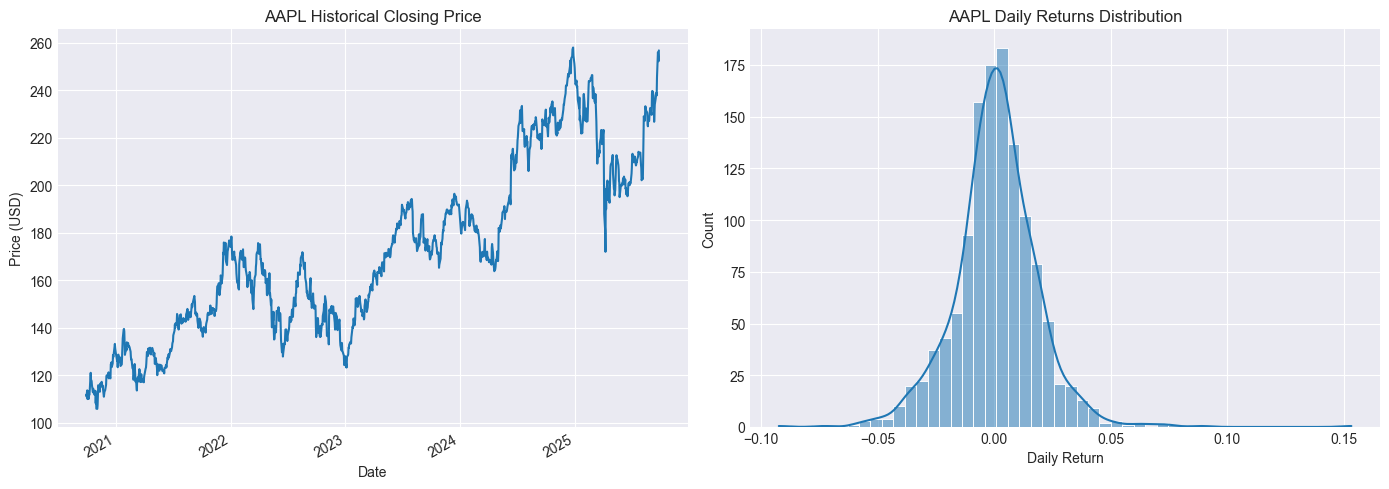

Saved plot: eda_plots/AAPL_price_and_returns.png

[D] Correlation Matrix (Stock Price vs Macro):


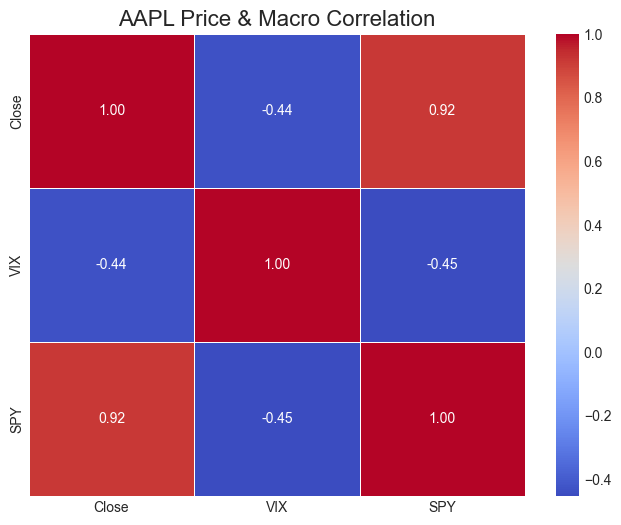

Saved plot: eda_plots/AAPL_price_macro_correlation.png

[E] Correlation Matrix (Stock Returns vs Macro Changes):
VIX_Change   -0.529390
SPY_Change    0.756528
------------------------------

[STEP 3: BASELINE MODELING AND EVALUATION]

--- Running Linear Regression Baseline for AAPL ---
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.

Linear Regression Baseline RMSE (7-Day Avg) for AAPL: 14.78
Linear Regression Baseline MAPE (7-Day Avg) for AAPL: 5.33%


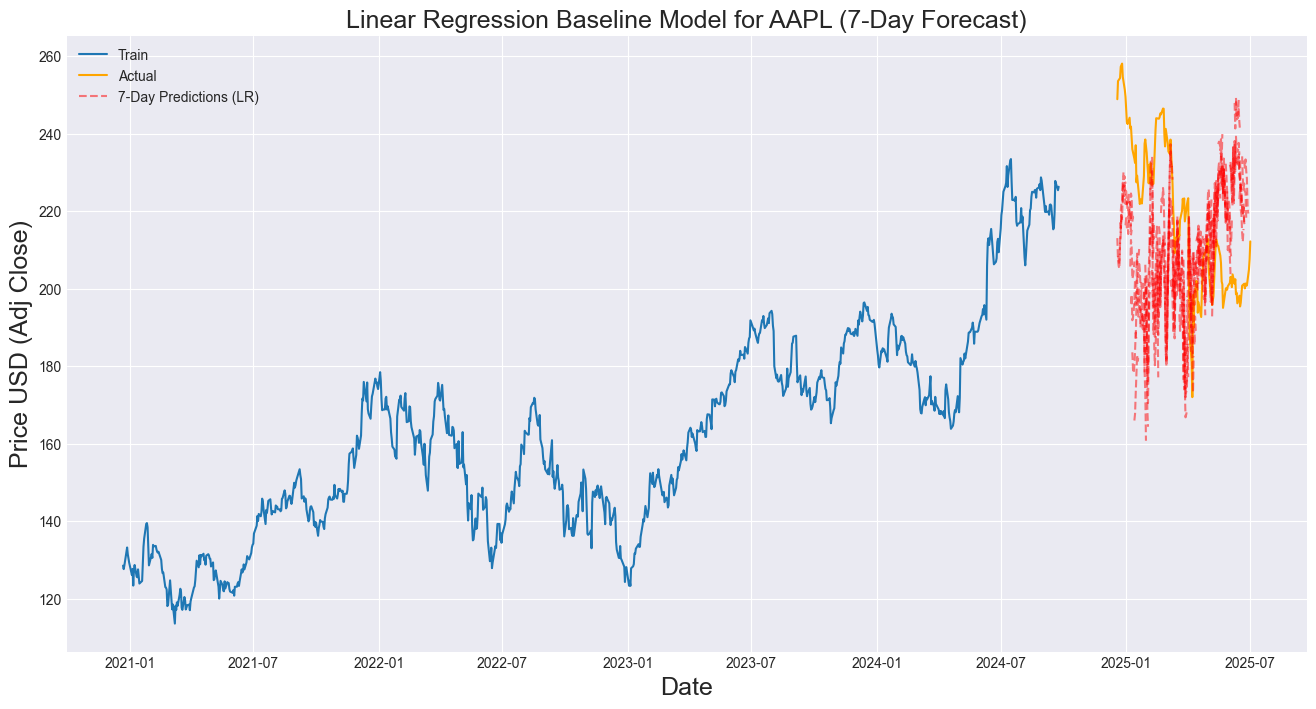

[*********************100%***********************]  1 of 1 completed

Saved plot: eda_plots/AAPL_lr_baseline_forecast.png
--- AAPL WORKFLOW COMPLETE ---

#####################################################
### PROCESSING FULL WORKFLOW FOR GOOG ###
#####################################################

[STEP 1: DATA ACQUISITION AND MACRO DATA INTEGRATION]
Deleted corrupted file: top_usa_stocks_data/GOOG_2020-09-26_2025-09-26.csv
Downloaded and saved fresh data for GOOG.
Successfully downloaded ^VIX. Head of data (Timezone Removed):
                 Open       High        Low      Close  Volume
Date                                                          
2020-09-28  27.150000  27.190001  24.900000  26.190001       0
2020-09-29  26.809999  27.430000  25.980000  26.270000       0
2020-09-30  26.690001  27.120001  25.059999  26.370001       0
2020-10-01  25.780001  27.110001  25.330000  26.700001       0
2020-10-02  28.870001  29.900000  26.930000  27.629999       0
------------------------------
Successfully downloaded SPY. Head of data (Timezone Removed

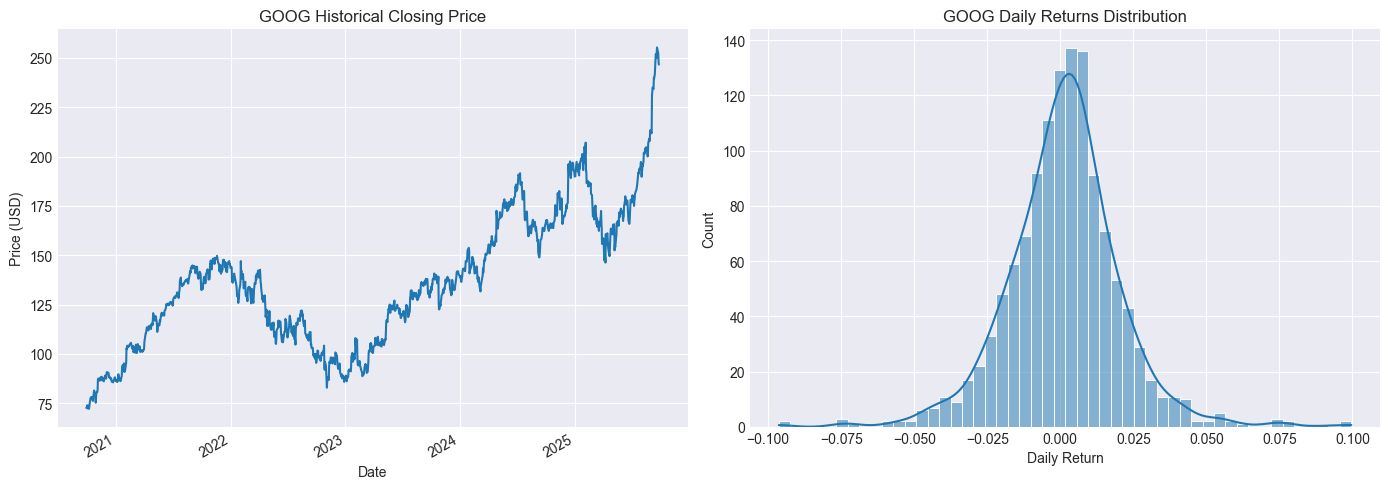

Saved plot: eda_plots/GOOG_price_and_returns.png

[D] Correlation Matrix (Stock Price vs Macro):


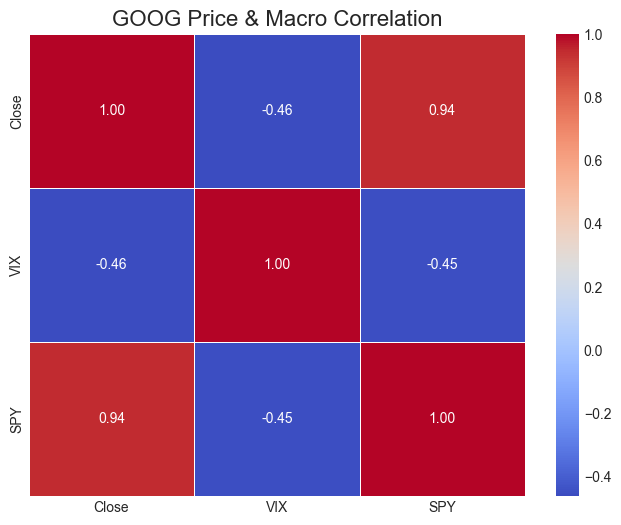

Saved plot: eda_plots/GOOG_price_macro_correlation.png

[E] Correlation Matrix (Stock Returns vs Macro Changes):
VIX_Change   -0.497710
SPY_Change    0.695684
------------------------------

[STEP 3: BASELINE MODELING AND EVALUATION]

--- Running Linear Regression Baseline for GOOG ---
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.

Linear Regression Baseline RMSE (7-Day Avg) for GOOG: 10.33
Linear Regression Baseline MAPE (7-Day Avg) for GOOG: 4.42%


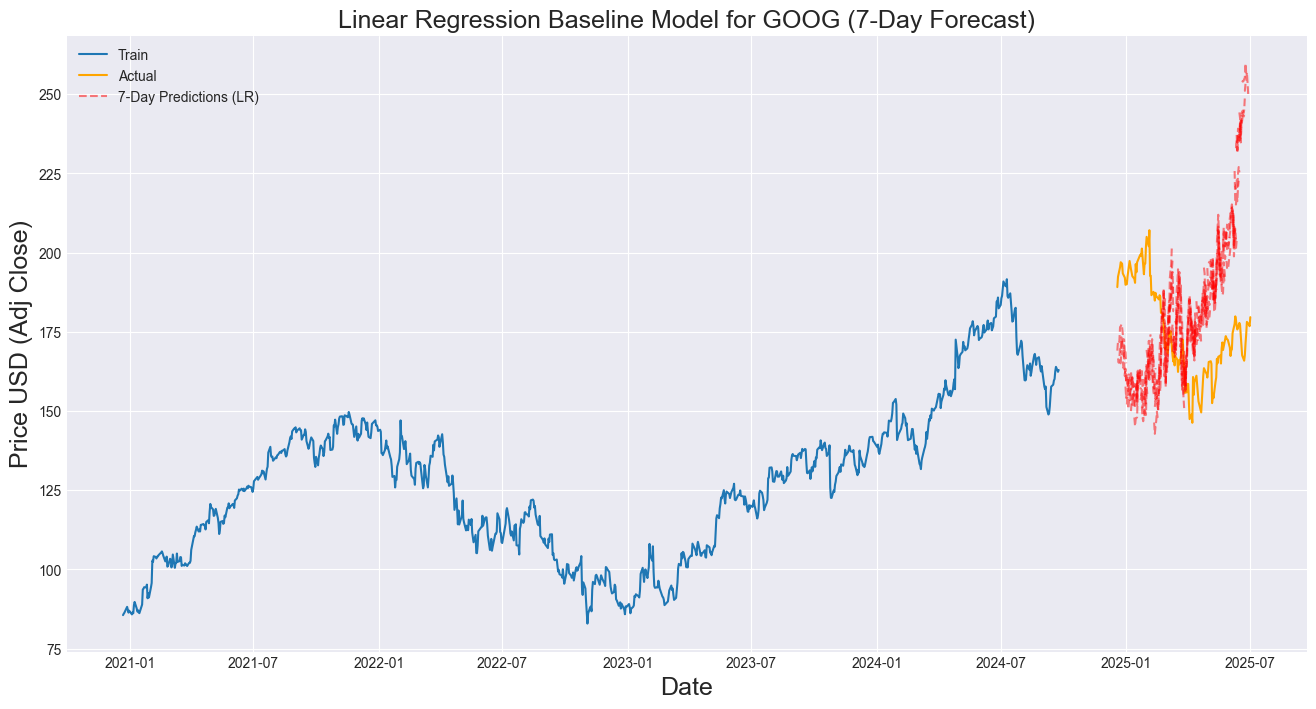

[*********************100%***********************]  1 of 1 completed

Saved plot: eda_plots/GOOG_lr_baseline_forecast.png
--- GOOG WORKFLOW COMPLETE ---

#####################################################
### PROCESSING FULL WORKFLOW FOR MSFT ###
#####################################################

[STEP 1: DATA ACQUISITION AND MACRO DATA INTEGRATION]
Deleted corrupted file: top_usa_stocks_data/MSFT_2020-09-26_2025-09-26.csv
Downloaded and saved fresh data for MSFT.
Successfully downloaded ^VIX. Head of data (Timezone Removed):
                 Open       High        Low      Close  Volume
Date                                                          
2020-09-28  27.150000  27.190001  24.900000  26.190001       0
2020-09-29  26.809999  27.430000  25.980000  26.270000       0
2020-09-30  26.690001  27.120001  25.059999  26.370001       0
2020-10-01  25.780001  27.110001  25.330000  26.700001       0
2020-10-02  28.870001  29.900000  26.930000  27.629999       0
------------------------------
Successfully downloaded SPY. Head of data (Timezone Removed

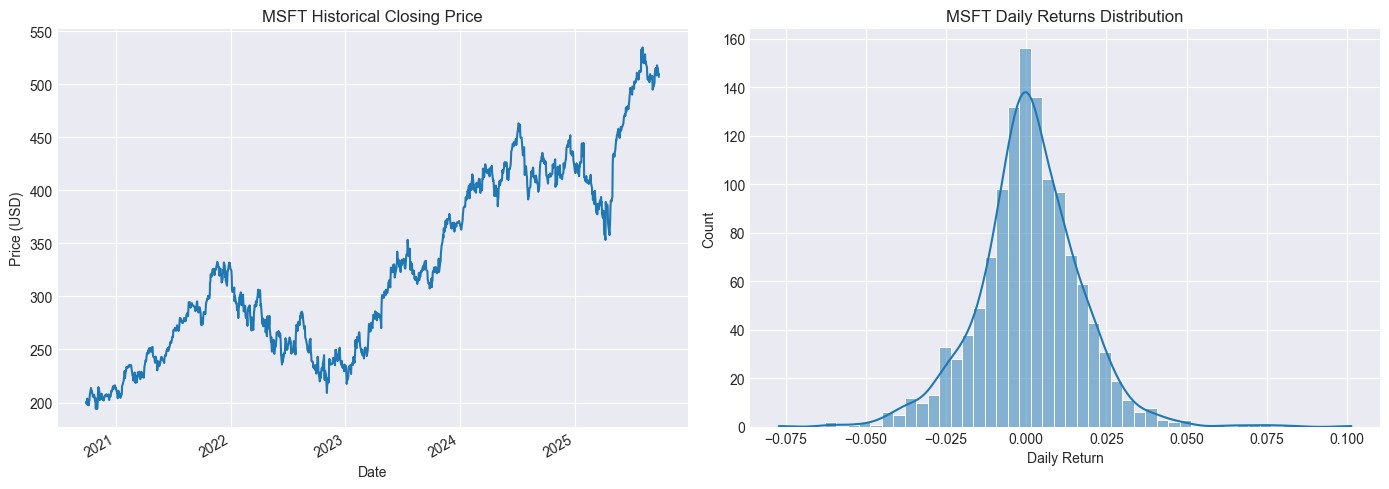

Saved plot: eda_plots/MSFT_price_and_returns.png

[D] Correlation Matrix (Stock Price vs Macro):


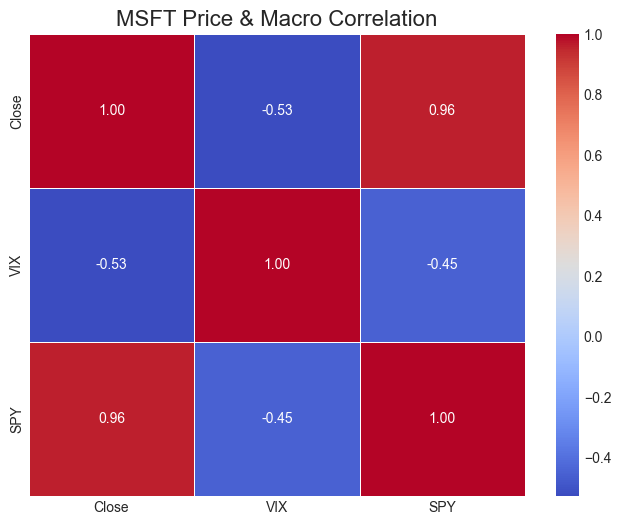

Saved plot: eda_plots/MSFT_price_macro_correlation.png

[E] Correlation Matrix (Stock Returns vs Macro Changes):
VIX_Change   -0.528299
SPY_Change    0.764408
------------------------------

[STEP 3: BASELINE MODELING AND EVALUATION]

--- Running Linear Regression Baseline for MSFT ---
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.

Linear Regression Baseline RMSE (7-Day Avg) for MSFT: 27.53
Linear Regression Baseline MAPE (7-Day Avg) for MSFT: 4.35%


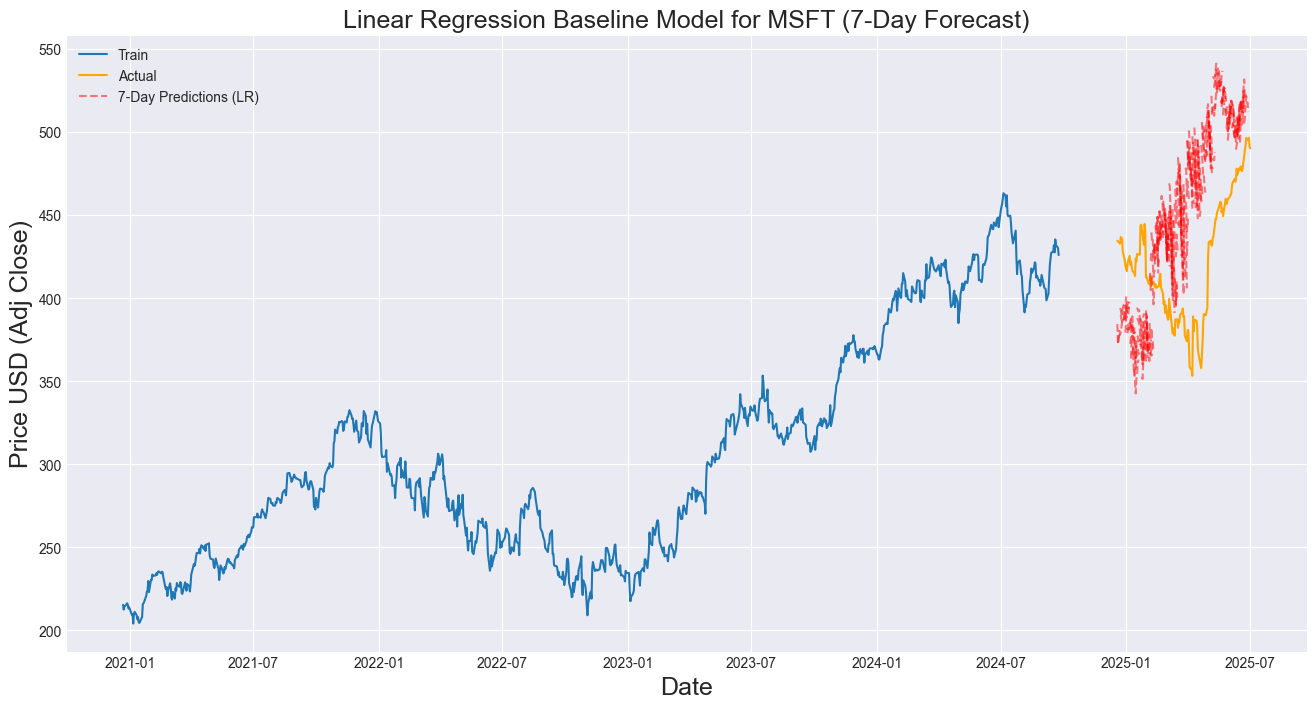

[*********************100%***********************]  1 of 1 completed

Saved plot: eda_plots/MSFT_lr_baseline_forecast.png
--- MSFT WORKFLOW COMPLETE ---

#####################################################
### PROCESSING FULL WORKFLOW FOR TSLA ###
#####################################################

[STEP 1: DATA ACQUISITION AND MACRO DATA INTEGRATION]
Deleted corrupted file: top_usa_stocks_data/TSLA_2020-09-26_2025-09-26.csv
Downloaded and saved fresh data for TSLA.
Successfully downloaded ^VIX. Head of data (Timezone Removed):
                 Open       High        Low      Close  Volume
Date                                                          
2020-09-28  27.150000  27.190001  24.900000  26.190001       0
2020-09-29  26.809999  27.430000  25.980000  26.270000       0
2020-09-30  26.690001  27.120001  25.059999  26.370001       0
2020-10-01  25.780001  27.110001  25.330000  26.700001       0
2020-10-02  28.870001  29.900000  26.930000  27.629999       0
------------------------------
Successfully downloaded SPY. Head of data (Timezone Removed

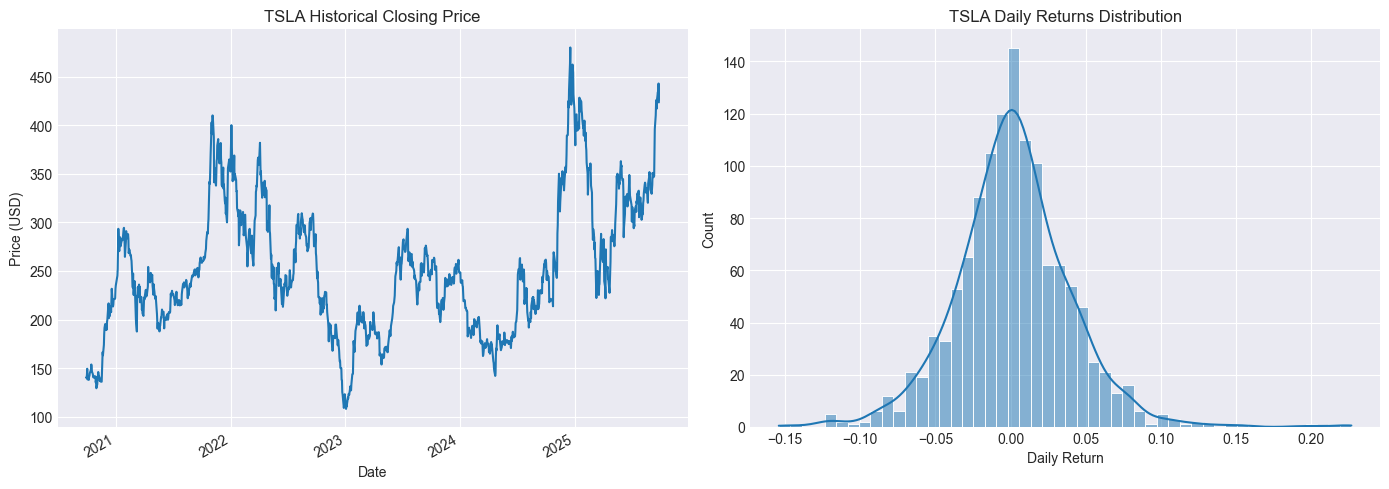

Saved plot: eda_plots/TSLA_price_and_returns.png

[D] Correlation Matrix (Stock Price vs Macro):


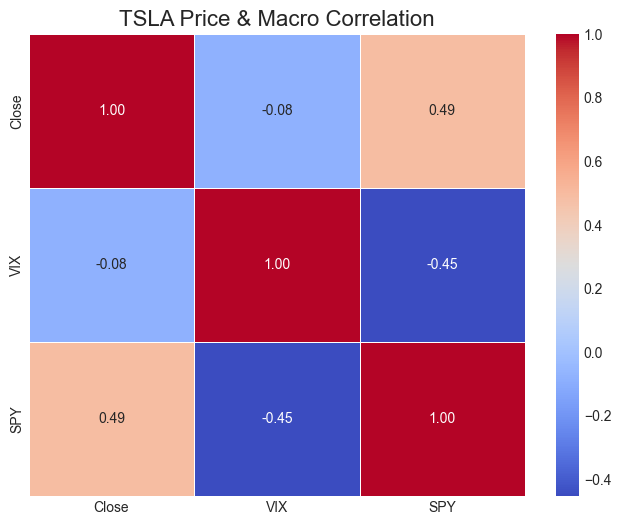

Saved plot: eda_plots/TSLA_price_macro_correlation.png

[E] Correlation Matrix (Stock Returns vs Macro Changes):
VIX_Change   -0.423862
SPY_Change    0.556265
------------------------------

[STEP 3: BASELINE MODELING AND EVALUATION]

--- Running Linear Regression Baseline for TSLA ---
Creating features: Input window=60 days, Output window=7 days.
Creating features: Input window=60 days, Output window=7 days.

Linear Regression Baseline RMSE (7-Day Avg) for TSLA: 40.19
Linear Regression Baseline MAPE (7-Day Avg) for TSLA: 9.97%


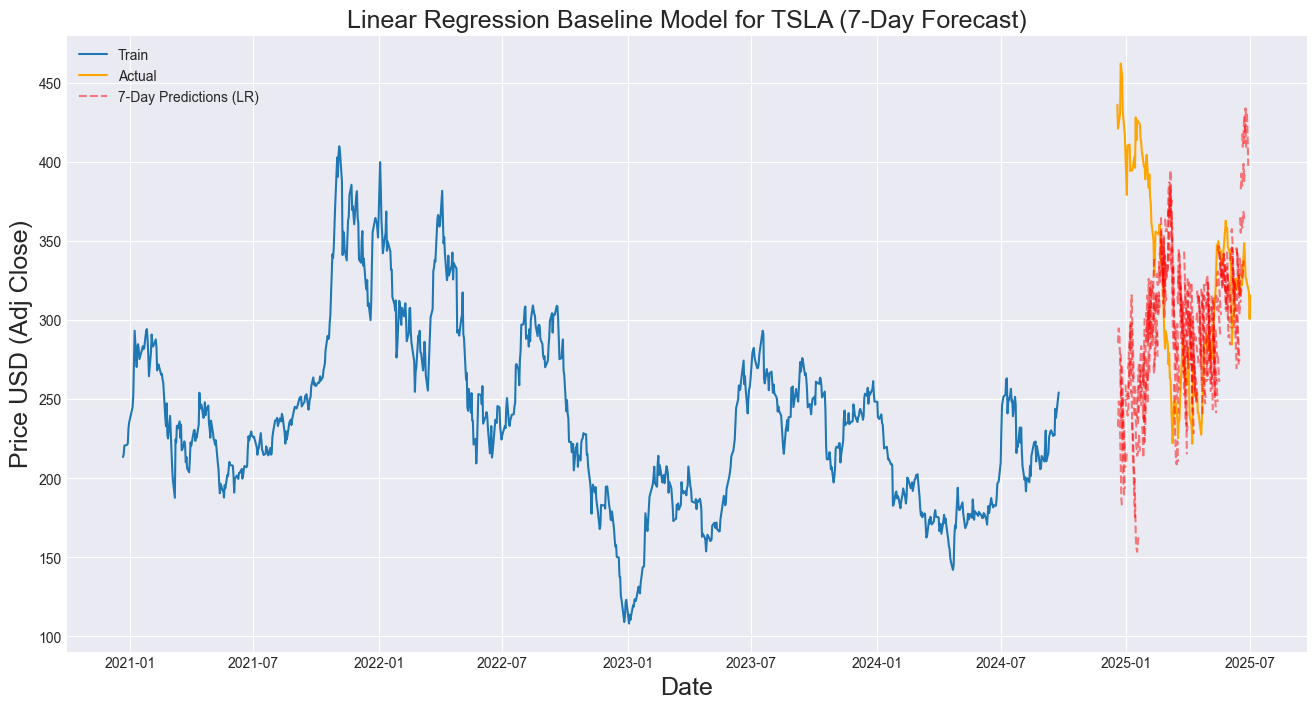

Saved plot: eda_plots/TSLA_lr_baseline_forecast.png
--- TSLA WORKFLOW COMPLETE ---

[STEP 4: SAVING FINAL RESULTS]
All Linear Regression RMSE and MAPE scores saved to: results/linear_regression_baseline_results.csv


In [396]:
# MAIN LOOP FOR CODE EXECUTION
for ticker in stock_tickers:
    print(f"\n#####################################################")
    print(f"### PROCESSING FULL WORKFLOW FOR {ticker} ###")
    print(f"#####################################################")
    
    # 1. DATA ACQUISITION AND MACRO DATA INTEGRATION
    print("\n[STEP 1: DATA ACQUISITION AND MACRO DATA INTEGRATION]")
    df = get_stock_data(ticker, start_date, end_date)
    
    if df is None:
        print(f"Skipping {ticker} due to data acquisition failure.")
        continue

    df_processed = add_macro_features(df)

    # 2. EDA AND VISUALIZATION
    print("\n[STEP 2: EDA AND VISUALIZATION]")
    # Perform EDA and get the cleaned DataFrame back
    df_cleaned_for_modeling = perform_eda(df_processed.copy(), ticker)
    
    

    # 3. BASELINE MODELING AND EVALUATION
    print("\n[STEP 3: BASELINE MODELING AND EVALUATION]")
    metrics = run_baseline_model(df_cleaned_for_modeling, ticker)
    all_results[ticker] = metrics
    
    print(f"--- {ticker} WORKFLOW COMPLETE ---")

# --- FINAL RESULTS SAVING ---
print("\n[STEP 4: SAVING FINAL RESULTS]")
results_df = pd.DataFrame.from_dict(all_results, orient='index')
results_filepath = os.path.join(RESULTS_DIR, 'linear_regression_baseline_results.csv')
results_df.to_csv(results_filepath)
print(f"All Linear Regression RMSE and MAPE scores saved to: {results_filepath}")
